In [6]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter

┌ Info: Precompiling IterativeSolvers [42fd0dbc-a981-5370-80f2-aaf504508153]
└ @ Base loading.jl:1186
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1186


In [7]:
include("util.j")

getAD (generic function with 1 method)

In [13]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains

┌ Info: Precompiling MCMCChains [c7f686f2-ff18-58e9-bc7b-31028e88f75d]
└ @ Base loading.jl:1186
ERROR: LoadError: LoadError: InitError: cglobal: could not find symbol unif_rand_ptr in library /Users/luzhang/.julia/packages/Rmath/Py9gH/deps/usr/lib/libRmath-julia.dylib
Stacktrace:
 [1] __init__() at /Users/luzhang/.julia/packages/Rmath/Py9gH/src/Rmath.jl:47
 [2] _include_from_serialized(::String, ::Array{Any,1}) at ./loading.jl:633
 [3] _require_search_from_serialized(::Base.PkgId, ::String) at ./loading.jl:713
 [4] _require(::Base.PkgId) at ./loading.jl:937
 [5] require(::Base.PkgId) at ./loading.jl:858
 [6] require(::Module, ::Symbol) at ./loading.jl:853
 [7] include at ./boot.jl:326 [inlined]
 [8] include_relative(::Module, ::String) at ./loading.jl:1038
 [9] include at ./sysimg.jl:29 [inlined]
 [10] include(::String) at /Users/luzhang/.julia/packages/StatsFuns/2QE7p/src/StatsFuns.jl:3
 [11] top-level scope at none:0
 [12] include at ./boot.jl:326 [inlined]
 [13] include_relative(::M

ErrorException: Failed to precompile MCMCChains [c7f686f2-ff18-58e9-bc7b-31028e88f75d] to /Users/luzhang/.julia/compiled/v1.1/MCMCChains/QRkwo.ji.

In [11]:
#using Pkg
#Pkg.add("MCMCChains");

 Resolving package versions...
 Installed RangeArrays ── v0.3.1
 Installed IntervalSets ─ v0.3.1
 Installed MCMCChains ─── v0.3.4
 Installed IterTools ──── v1.1.1
 Installed AxisArrays ─── v0.3.0
  Updating `~/.julia/environments/v1.1/Project.toml`
  [c7f686f2] + MCMCChains v0.3.4
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [39de3d68] + AxisArrays v0.3.0
  [8197267c] + IntervalSets v0.3.1
  [c8e1da08] + IterTools v1.1.1
  [c7f686f2] + MCMCChains v0.3.4
  [b3c3ace0] + RangeArrays v0.3.1


In [101]:
# Set the parameters for SLMC model #

N = 1200 # sample size
N1 = 1000; N2 = 1000;
q = 2; p = 2; K = 2
Σ = [0.3 0.1
     0.1 0.2];
β = [1.0 -1.0
     -5.0 2.0];
ϕ1 = 3.0; ϕ2 = 30.0; ν1 = 0.5; ν2 = 0.5; # parameter for the independent F
Λ = [1.0 -2.0
     -2.0 3.0];

# priors #
μβ = fill(0.0, p, q); Vβ =[[100.0 0.0]; [0.0 100.0]];
μΛ = fill(0.0, K, q); VΛ =[[100.0 0.0]; [0.0 100.0]];
νΣ = 2 * q; ΨΣ = [[1.0 0.0]; [0.0 1.0]];

In [102]:
# Generate simulation data #

Random.seed!(1234);
coords = rand(2, N);                                          # random location over unit square
X = hcat(fill(1, (N,)), rand(N));                             # design matrix
D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
ρ1 = exp.(-ϕ1 * D); ρ2 = exp.(-ϕ2 * D);                       # covariance matrix
ω = [rand(MvNormal(ρ1), 1) rand(MvNormal(ρ2), 1)] * Λ; # latent process
Y = X * β + ω + transpose(rand(MvNormal(Σ), N));              # response matrix

In [103]:
# Some data preparations #

ordx = sortperm(coords[1, :]);                                # sort order based on the first coordinates
X_ord = X[ordx, :]; Y_ord = Y[ordx, :]; ω_ord = ω[ordx, :];   # sorted data
coords_ord = coords[:, ordx];
S1_ind = sample(1:N, N1, replace = false, ordered = true);    # observed location index for 1st response
S2_ind = sample(1:N, N2, replace = false, ordered = true);    # observed location index for 2nd response
S = sort(union(S1_ind, S2_ind));                              # observed index set
M1_ind = setdiff(S, S1_ind);                                  # in S not in S1
M2_ind = setdiff(S, S2_ind);                                  # in S not in S2 
obs_ind = vcat(S1_ind, S2_ind .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S1_ind, S2_ind));                    # the vector of the permutation 

v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
M1_Sind = findall(x -> x == 2^1, index_S[S]);                 # index of M1 among S
M2_Sind = findall(x -> x == 2^0, index_S[S]);                 # index of M2 among S

m = 10; n = length(S);                                        # number of nearest neighbor                       
NN = BuildNN(coords_ord[:, S], m, 1.0);                            # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

Lβ = cholesky(Vβ); LΛ = cholesky(VΛ);

In [104]:
# preallocation #

#F = Array{Float64,2}(undef, n , 3);                           # preallocate the matrix F
μ_m1 = Array{Float64, 2}(undef, length(M1_ind), q);
μ_m2 = Array{Float64, 2}(undef, length(M2_ind), q);
nIndx = length(NN.nnIndx);
A1 = Array{Float64}(undef, nIndx); D1 = Array{Float64}(undef, n);
A2 = Array{Float64}(undef, nIndx); D2 = Array{Float64}(undef, n);
Ystar = vcat(Y_ord[S, :], Lβ.L \ μβ, LΛ.L \ μΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] fill(0.0, n, K)], [inv(Lβ.L) fill(0.0, p, K)], 
    [fill(0.0, K, p) inv(LΛ.L)]);      
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [105]:
# Preallocation for MCMC samples and Initalization #
N_sam = 25000;
γ_sam = Array{Float64, 3}(undef, p + K, q, N_sam + 1);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam + 1);
vF_sam = Array{Float64, 2}(undef, K * n, N_sam);
Y_m1_sam = Array{Float64, 2}(undef, length(M1_ind), N_sam);
Y_m2_sam = Array{Float64, 2}(undef, length(M2_ind), N_sam);

ϕ1_0 = ϕ1; ϕ2_0 = ϕ2; 
γ_sam[:, :, 1] = vcat(X \ Y, [[1.0 0.0]; [0.0 1.0]]);
Σ_sam[:, :, 1] = [[0.5 0.1]; [0.1 0.5]];

# first consider SLMC with fixed hyperparameter set {ψk} #
# Build the matrix Vk #
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ1_0, 0.5, A1, D1);
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ2_0, 0.5, A2, D2);

In [106]:
# for loop for MCMC chain #
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][1, 1])), 
        2^1 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][2, 2])), 
        (2^0 + 2^1)=> sparse(sqrt(inv(Σ_sam[:, :, l]))));
    invD = blockdiag([Dic_diag[i] for i in index_S if i > 0]...);
                    
    # first consider SLMC with fixed hyperparameter set {ψk} #
    # Build the matrix Vk #
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ1_0, 0.5, A1, D1);
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ2_0, 0.5, A2, D2);
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ3_0, 0.5, A3, D3);

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S1_ind, 1], Y_ord[S2_ind, 2])[perm_ind], zeros(K * n));
    Xtilde = vcat(
             invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :, l])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, 
                            vcat(S, S .+ N)][perm_ind, :],
             blockdiag(
             Diagonal(1 ./ sqrt.(D1)) * sparse(nnIndx_row, nnIndx_col, vcat(-A1, ones(n))),
             Diagonal(1 ./ sqrt.(D2)) * sparse(nnIndx_row, nnIndx_col, vcat(-A2, ones(n)))))
                
    # use LSMR to generate sample of F #       
    nsam = length(Ytilde);
    vF_sam[:, l] = lsmr(Xtilde, Ytilde + rand(Normal(), nsam));
                    
    # impute missing response  over S#
    Xstar[1:n, (p + 1):(p + K)] = reshape(vF_sam[:, l], :, K);        # update matrix Xstar with F
    mul!(μ_m1, Xstar[M1_Sind, :], γ_sam[:, :, l]);
    mul!(μ_m2, Xstar[M2_Sind, :], γ_sam[:, :, l]);

    Y_m1_sam[:, l] = μ_m1[:, 1] + (Σ_sam[1, 2, l] / Σ_sam[2, 2, l]) * 
            (Y_ord[M1_ind, 2] - μ_m1[:, 2]) + 
            rand(Normal(0, sqrt(Σ_sam[1, 1, l] - Σ_sam[1, 2, l]^2 / Σ_sam[2, 2, l])), length(M1_ind));
    Y_m2_sam[:, l] = μ_m2[:, 2] + (Σ_sam[2, 1, l] / Σ_sam[1, 1, l]) * 
            (Y_ord[M2_ind, 1] - μ_m2[:, 1]) + 
            rand(Normal(0, sqrt(Σ_sam[2, 2, l] - Σ_sam[2, 1, l]^2 / Σ_sam[1, 1, l])), length(M2_ind)); # improve?...
                    
    # use MNIW to sample γ Σ #
    Ystar[M1_Sind, 1] = Y_m1_sam[:, l];              # update Ystar with imputed response
    Ystar[M2_Sind, 2] = Y_m2_sam[:, l]; 
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam[:, :, l + 1] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam[:, :, l + 1] = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) * 
                    cholesky(Σ_sam[:, :, l + 1]).U + μγstar;          # sample γ    
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 1:45:13


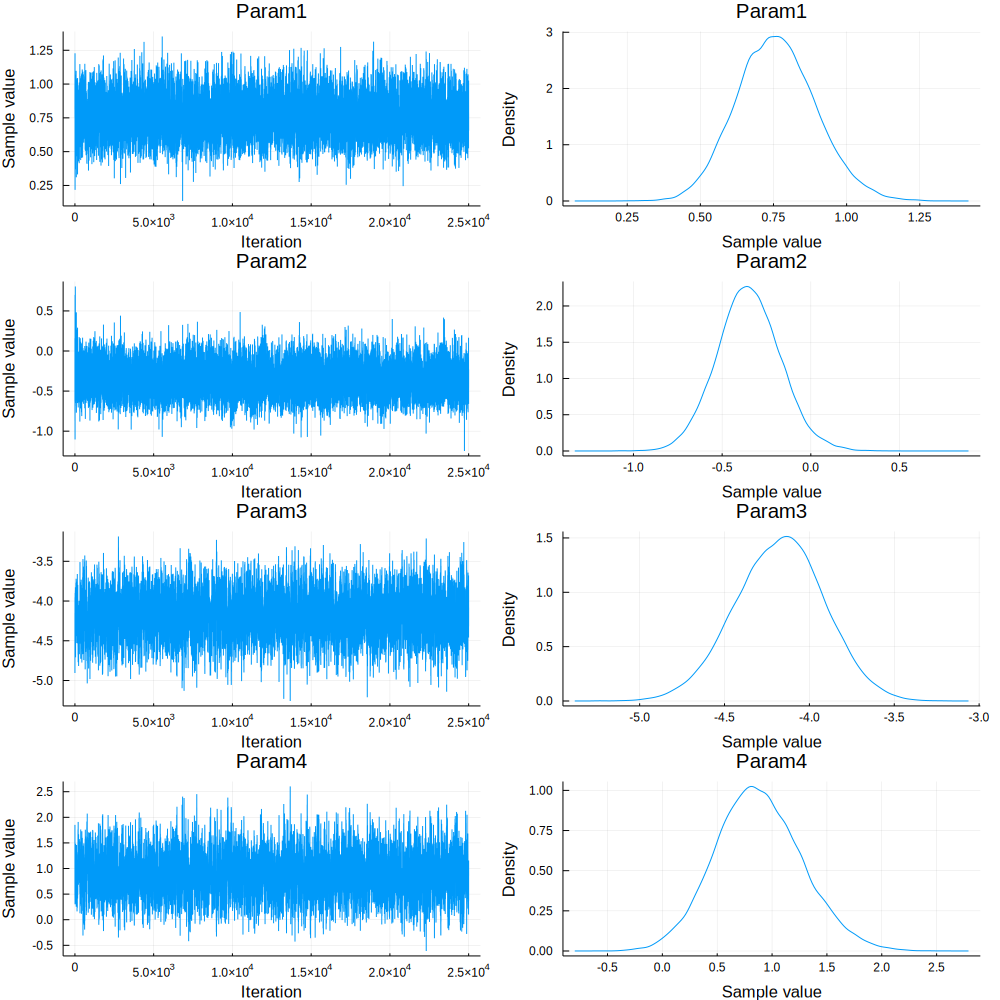

In [107]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

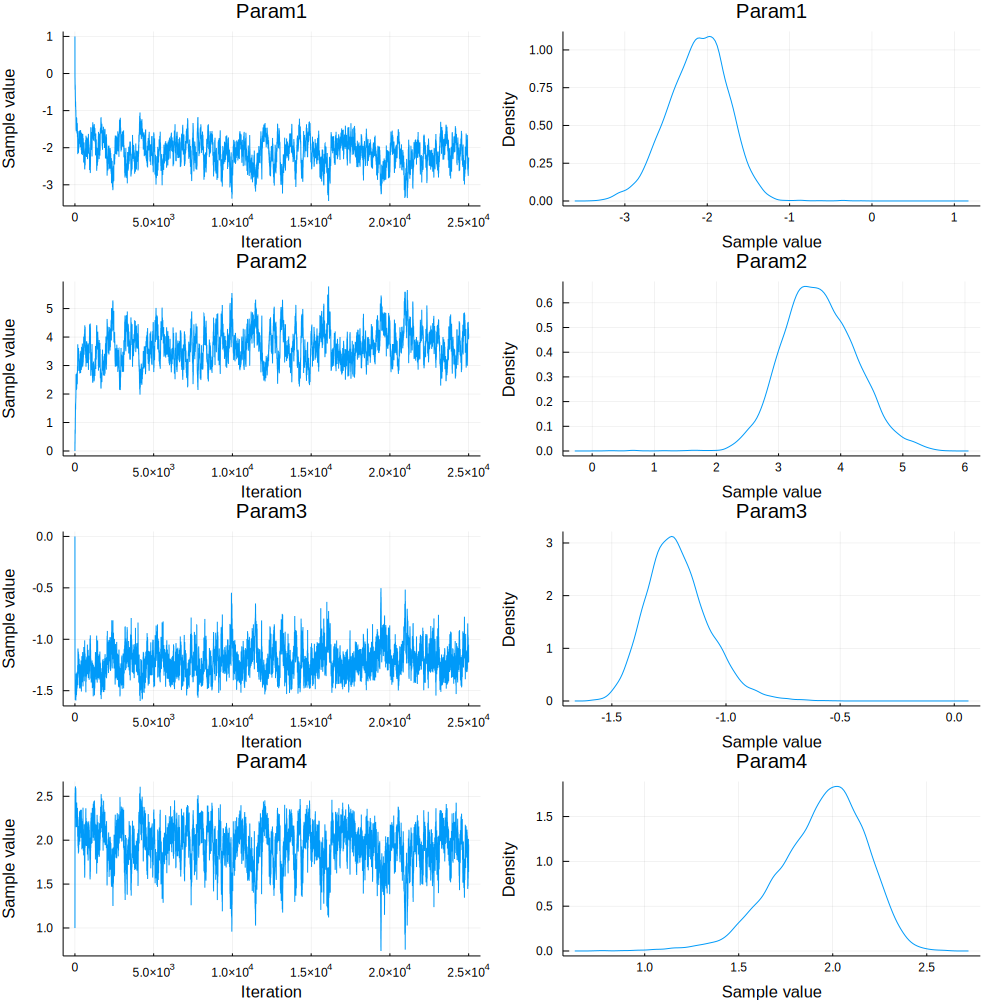

In [108]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[3, 1, :], γ_sam[3, 2, :], γ_sam[4, 1, :], γ_sam[4, 2, :]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

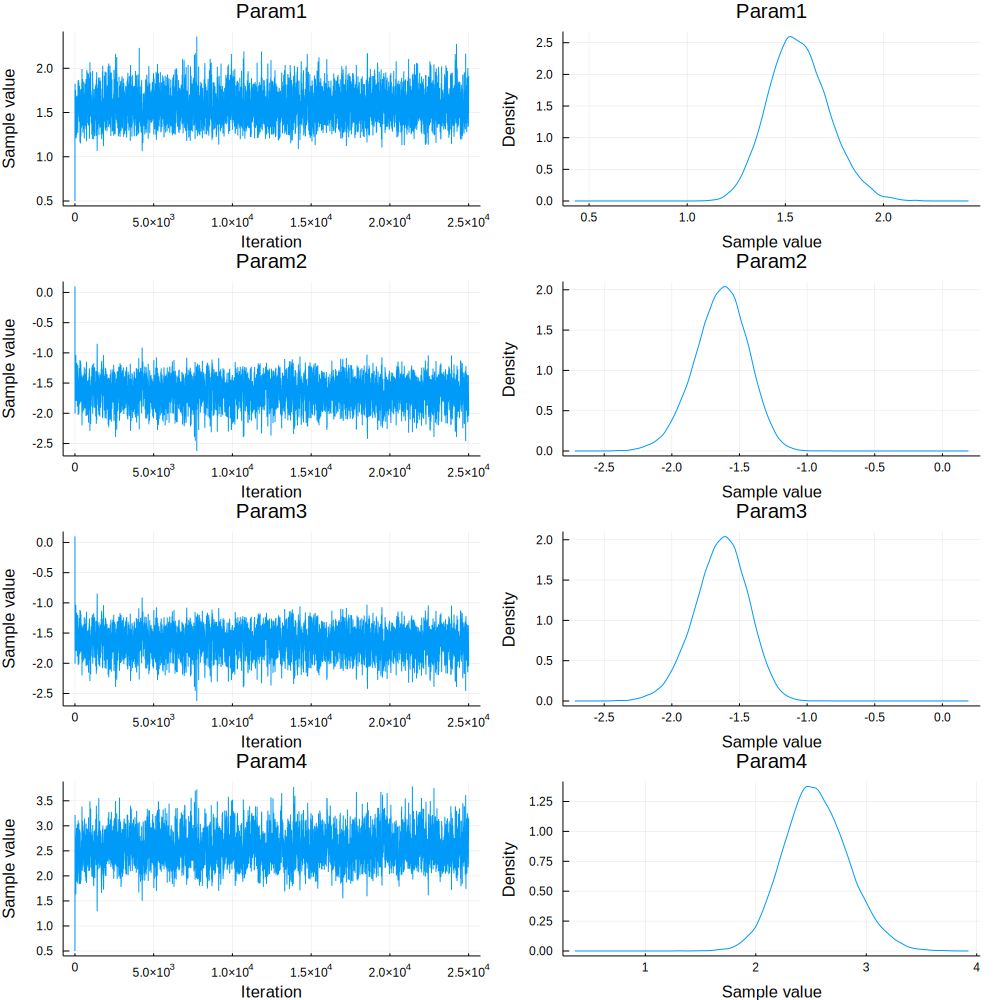

In [109]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, :], Σ_sam[1, 2, :], Σ_sam[2, 1, :], Σ_sam[2, 2, :]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [95]:
sqrt(inv(Σ))

2×2 Array{Float64,2}:
  1.9465    -0.459506
 -0.459506   2.406   